In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.io as scp
import itertools

Generate Random Noise

<AxesSubplot:>

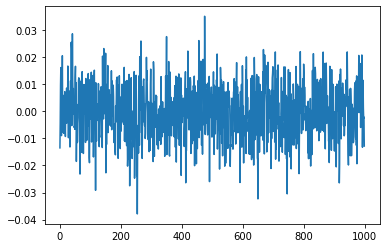

In [3]:
samples = np.random.normal(scale=0.01, size=1000)

sns.lineplot(x=range(1000), y=samples)

Generate random walk

<AxesSubplot:>

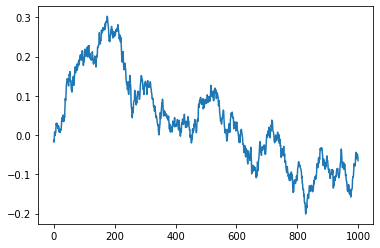

In [4]:
summed_samp = []

for i in range(len(samples)):
    summed_samp.append(np.sum(samples[:i+1]))
    
    
sns.lineplot(x=range(1000), y = summed_samp)

# Multifractal analysis

## Load data

In [5]:
matlab_data = scp.loadmat("Introduction_to_MFDFA4/fractaldata.mat")

# matlab_data['multifractal']
matlab_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar 19 20:14:08 2012',
 '__version__': '1.0',
 '__globals__': [],
 'multifractal': array([[0.22501543],
        [0.3884828 ],
        [0.49273619],
        ...,
        [3.16942304],
        [2.82570379],
        [0.70937846]]),
 'monofractal': array([[-0.98290635],
        [-1.10429331],
        [-0.58353707],
        ...,
        [-0.36444405],
        [-1.0112384 ],
        [ 0.01318624]]),
 'whitenoise': array([[-0.15087142],
        [-0.98170845],
        [ 0.6042954 ],
        ...,
        [-0.63006538],
        [-1.0862512 ],
        [ 0.49630978]])}

In [6]:
def noise_to_walk(noise_series): return np.cumsum(noise_series - np.mean(noise_series))

def RMS(walk, q=2): return np.mean(walk**q)**(1/q) if q != 0 else np.exp(0.5*np.mean(np.log2(walk)**2))
        

In [7]:
whitenoise_noise = np.squeeze(matlab_data['whitenoise'])
monofractal_noise = np.squeeze(matlab_data['monofractal'])
multifractal_noise = np.squeeze(matlab_data['multifractal'])

whitenoise_walk = noise_to_walk(whitenoise_noise)
monofractal_walk = noise_to_walk(monofractal_noise)
multifractal_walk = noise_to_walk(multifractal_noise)

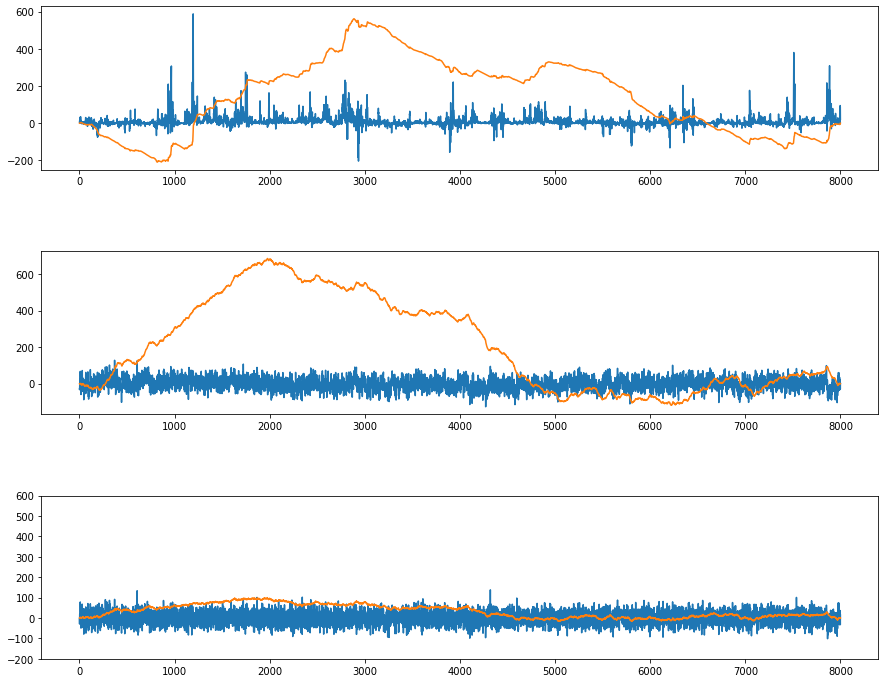

In [8]:
x = range(len(whitenoise_noise))

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,12))

magnifier = 30

ax1.plot(x, multifractal_noise*magnifier)
ax1.plot(x, multifractal_walk)
ax2.plot(x, monofractal_noise*magnifier)
ax2.plot(x, monofractal_walk)
ax3.plot(x, whitenoise_noise*magnifier)
ax3.plot(x, whitenoise_walk)
ax3.set_ylim([-200, 600])

# plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)
plt.show()

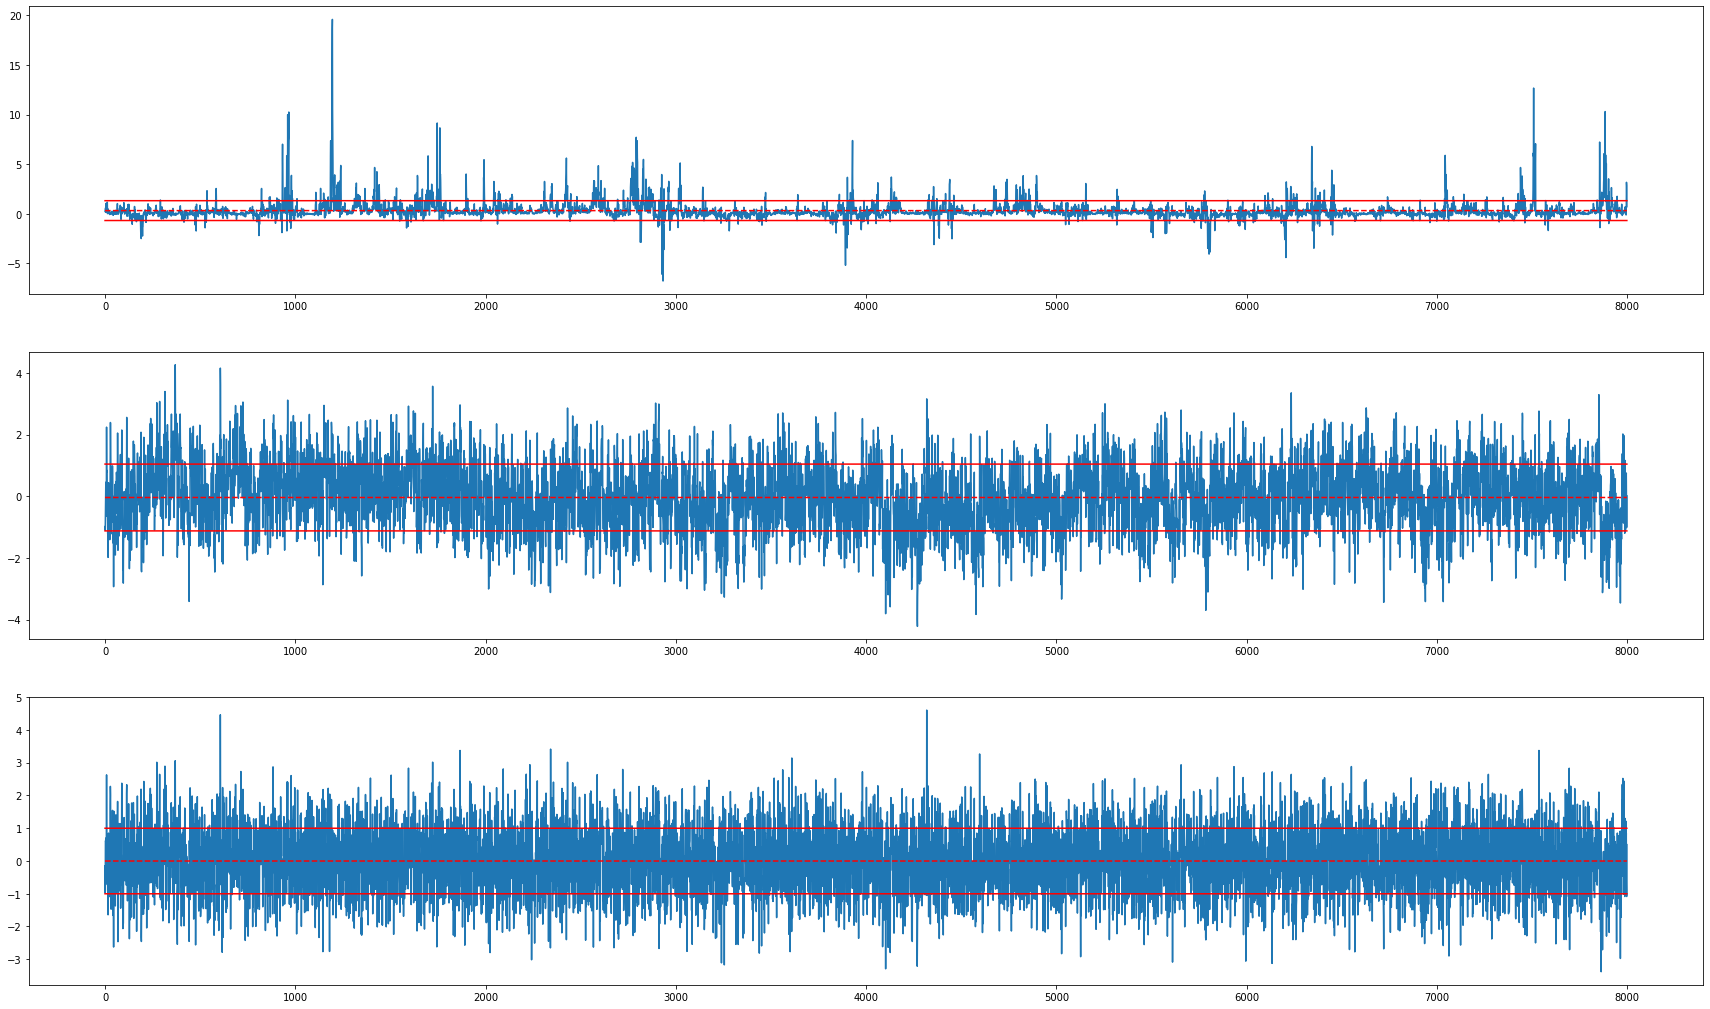

In [9]:

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(30,18))

def rms_plot(noise, ax):
    
    mean = np.repeat(np.mean(noise), len(noise))
    rms = RMS(noise)
    
    ax.plot(noise)
    ax.plot(mean, "--r")
    ax.plot(mean - rms, "r")
    ax.plot(mean + rms, "r")
    
    return ax

rms_plot(multifractal_noise, ax1)
rms_plot(monofractal_noise, ax2)
rms_plot(whitenoise_noise, ax3)

plt.show()

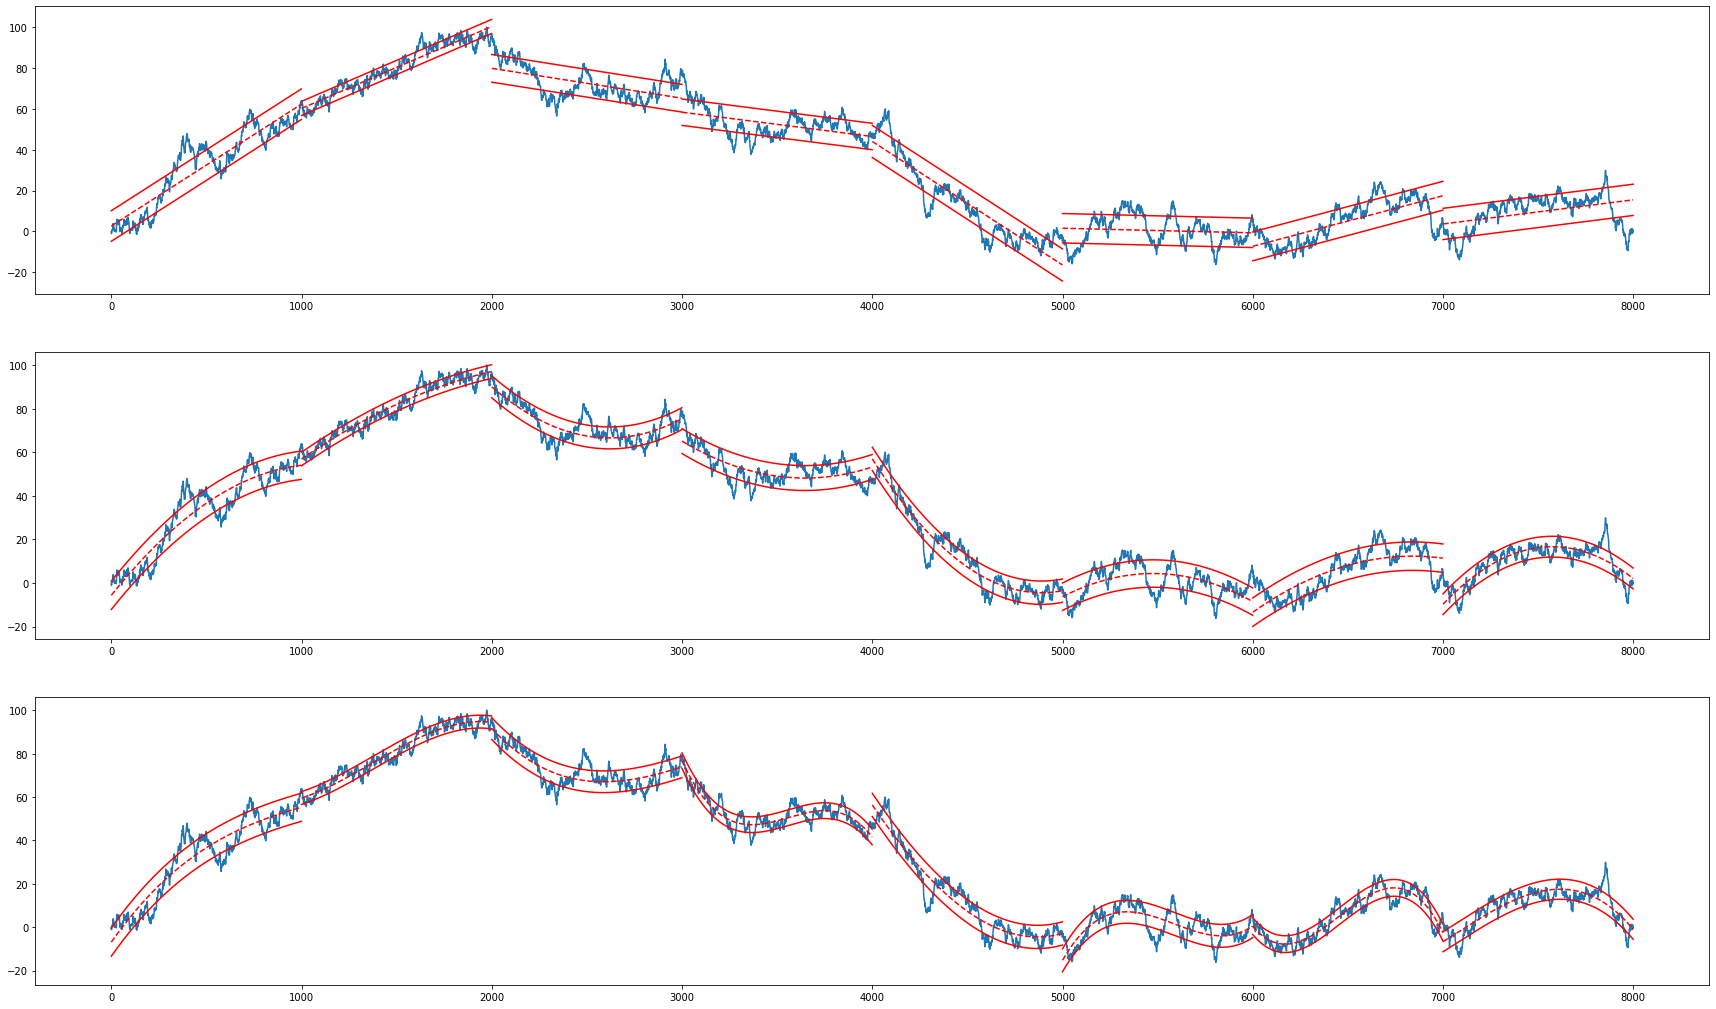

In [10]:
def local_RMS(walk, scale, degree):
        
    segments = int(np.floor(len(walk)/scale))
    
    predictions = []
    fluctuations = []
    
    for seg in range(segments):
        
        start = seg*scale
        end = seg*scale + scale
        
        x = np.arange(start, end)
        y_observed = walk[x]
        
        fit = np.polyfit(x, y_observed, degree)
        y_predicted = np.polyval(fit, x)
        
        local_fluctuation = RMS(y_observed - y_predicted)
        
        predictions.append(y_predicted)
        fluctuations.append(local_fluctuation)
        
    return np.array(fluctuations), predictions



def plot_local_trends(fluctuations, predictions, ax):
    
    for i in range(len(fluctuations)):
        
        y_pred = predictions[i]
        segment_size = len(y_pred)
        
        start = i*segment_size
        end = start + segment_size
        x_segment = np.arange(start, end)
        
        
        rms = fluctuations[i]
        
        lower = y_pred - rms
        upper = y_pred + rms
        
        ax.plot(x_segment, y_pred, "--r")
        ax.plot(x_segment, lower, "r")
        ax.plot(x_segment, upper, "r")
        
    return ax

def trend_graph(walk, scale):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(30,18))
    
    fluc1, pred1 = local_RMS(walk, scale, 1)
    fluc2, pred2 = local_RMS(walk, scale, 2)
    fluc3, pred3 = local_RMS(walk, scale, 3)
    
    ax1.plot(walk)
    plot_local_trends(fluc1, pred1, ax1)
    ax2.plot(walk)
    plot_local_trends(fluc2, pred2, ax2)
    ax3.plot(walk)
    plot_local_trends(fluc3, pred3, ax3)
    
    plt.show()
    

trend_graph(whitenoise_walk, 1000)

Local Fluctuation at Multiple Scales

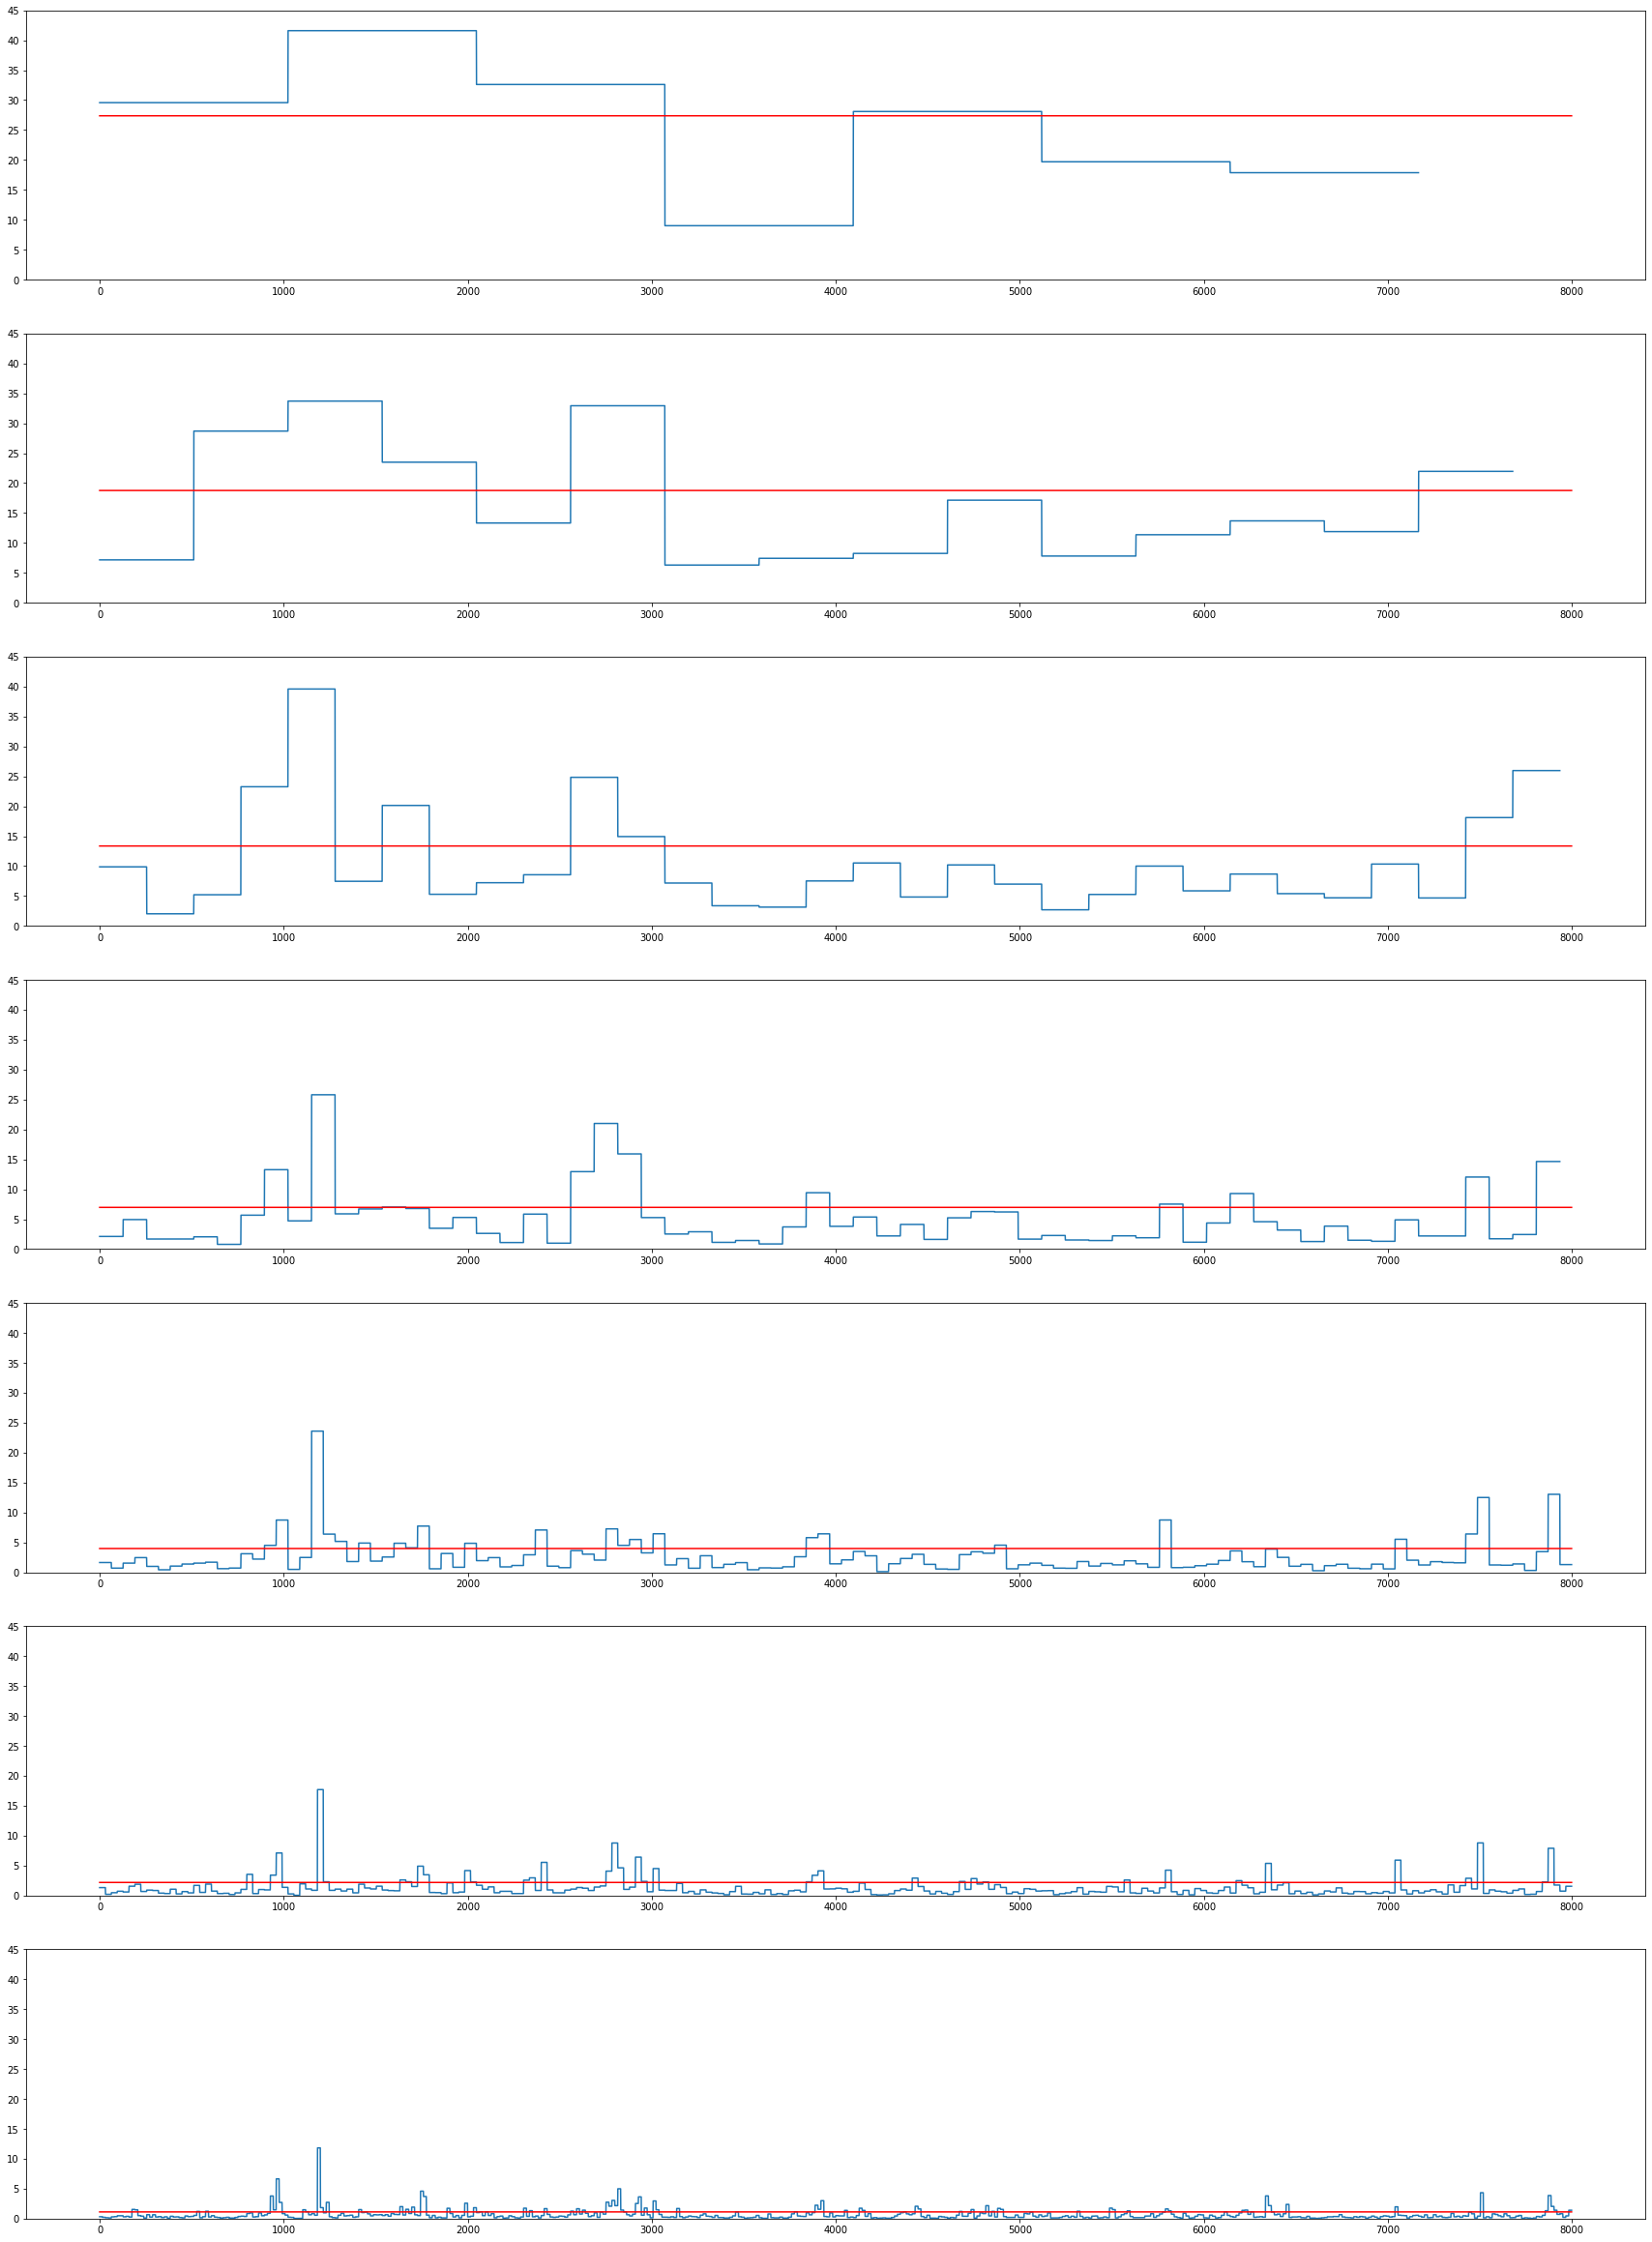

In [11]:
def compute_F_by_scale(walk, scales, graph=True):
    
    if graph:
        fig, axes = plt.subplots(len(scales), figsize=(30, len(scales)*6))
        
    rms_F_by_scale = []
    
    for i in range(len(scales)):
        
        scale = scales[i]
        
        fluctuations, _ = local_RMS(walk, scale, 1)
        
        F = RMS(np.array(fluctuations))
        rms_F_by_scale.append(F)
        
        if graph:
            
            local_rms = []
            for fluc in fluctuations:
                local_rms = local_rms + [fluc]*scale
                
            ax_i = axes[i]
            ax_i.plot(local_rms)
            ax_i.plot(range(len(walk)), [F]*len(walk), "r") 
            ax_i.set_ylim([0, 45])
    
    if graph:
        plt.show()
    
    return rms_F_by_scale
            
        

scales = [1024, 512, 256, 128, 64, 32, 16]

multifractal_F_by_scale = compute_F_by_scale(multifractal_walk, scales)

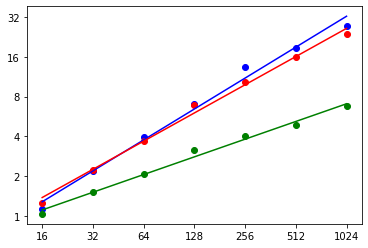

In [12]:


monofractal_F_by_scale = compute_F_by_scale(monofractal_walk, scales, graph=False)
whitenoise_F_by_scale = compute_F_by_scale(whitenoise_walk, scales, graph=False)

multifractal_fit = np.polyfit(np.log2(scales), np.log2(multifractal_F_by_scale), 1)
monofractal_fit = np.polyfit(np.log2(scales), np.log2(monofractal_F_by_scale), 1)
whitenoise_fit = np.polyfit(np.log2(scales), np.log2(whitenoise_F_by_scale), 1)

def compute_line_of_best_fit(params, x):
    x = np.array(x)
    x = np.concatenate((np.expand_dims(x, axis=1), np.ones((len(x), 1))), axis=1)
    
    return np.dot(x, params)
    
    
multifractal_best_fit = compute_line_of_best_fit(multifractal_fit, np.log2(scales))
monofractal_best_fit = compute_line_of_best_fit(monofractal_fit, np.log2(scales))
whitenoise_best_fit = compute_line_of_best_fit(whitenoise_fit, np.log2(scales))

plt.scatter(np.log2(scales), np.log2(multifractal_F_by_scale), c="b")
plt.scatter(np.log2(scales), np.log2(monofractal_F_by_scale), c="r")
plt.scatter(np.log2(scales), np.log2(whitenoise_F_by_scale), c="g")
plt.plot(np.log2(scales), multifractal_best_fit, "b")
plt.plot(np.log2(scales), monofractal_best_fit, "r")
plt.plot(np.log2(scales), whitenoise_best_fit, "g")
plt.xticks(ticks=range(4,11), labels=reversed(scales))
plt.yticks(ticks=range(6), labels=[2**i for i in range(6)])
plt.show()

Q order analysis

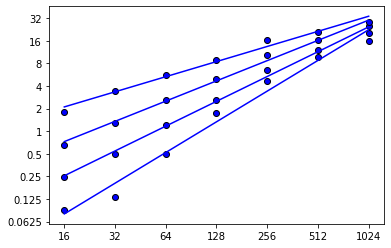

In [40]:
scales = [16, 32, 64, 128, 256, 512, 1024]
qs = [-3, -1, 1, 3]

def compute_F_by_scale_q(walk, scales, qs):

    rms_F_by_scale_q = []
    
    for scale in scales:
        
        fluctuations, _ = local_RMS(walk, scale, 1)
        
        rms_F_by_q = []
        
        for q in qs:
                 
            F = RMS(np.array(fluctuations), q=q)
            rms_F_by_q.append(F)
            
        
        rms_F_by_scale_q.append(rms_F_by_q)
            
    return np.array(rms_F_by_scale_q)


def draw_lines_by_q(F_by_scale_q, scales, qs):
    
    for i in range(len(qs)):
        
        Fs = F_by_scale_q[:,i]
        
        fit = np.polyfit(np.log2(scales), np.log2(Fs), 1)
        line = np.polyval(fit, np.log2(scales))
        
        plt.scatter(np.log2(scales), np.log2(Fs), c="b", edgecolor="k")
        plt.plot(np.log2(scales), line, "b")
        plt.xticks(ticks=range(4,11), labels=scales)
        plt.yticks(ticks=range(-4,6), labels=[2**i for i in range(-4,6)])
        
        
# fig, (ax1, ax2, ax3) = plt.subplots(3)

multifractal_F_by_scale_q = compute_F_by_scale_q(multifractal_walk, scales, qs)
draw_lines_by_q(multifractal_F_by_scale_q, scales, qs)
        

            

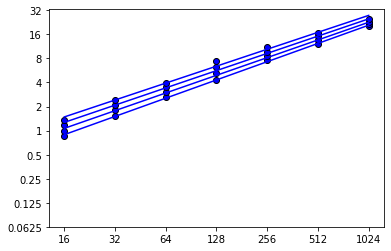

In [41]:
monofractal_F_by_scale_q = compute_F_by_scale_q(monofractal_walk, scales, qs)
draw_lines_by_q(monofractal_F_by_scale_q, scales, qs)

What seems to be driving the difference here is that lower q orders have significantly lower q order rms at small scales. At high scales everything seems to be be roughly the same.

## Fluctuation at different qs

In [102]:
def plot_q_fluctuation(walk, scale, qs=[1,-1], axis_limit=None):
    
    fluctuations, _ = local_RMS(walk, scale, 1)
    q_modified_fluctuations = []
    for q in qs:
        q_modified = fluctuations**q
        q_modified_fluctuations.append(q_modified)
        
#     segments = int(np.floor(len(walk)/scale))
        
    fluctuation_series_list = []
    for i in range(len(qs)):
        fluctuations = q_modified_fluctuations[i]
        fluctuation_series = np.concatenate([np.repeat(fluc, scale) for fluc in fluctuations]).ravel()
        fluctuation_series_list.append(fluctuation_series)
        
    num_plots = len(qs) + 1
    fig, axes = plt.subplots(num_plots, figsize=(30,4*num_plots))
    
#     x_axis = range(len(walk))
    axes[0].plot(walk)
    for i in range(len(qs)):
        fluctuation_series = fluctuation_series_list[i]
        axes[i+1].plot(fluctuation_series)
        if axis_limit != None:
            axes[i+1].set_ylim(axis_limit)
        
    return axes
        
        
    
def compare_fluctuation_at_scale(walk):
    
    fluctuation_small_scale, _ = local_RMS(walk, 16, 1)
    fluctuation_large_scale, _ = local_RMS(walk, 1024, 1)
    
    q_range = np.arange(-3, 3, .1)
    F_small_scale = [RMS(fluctuation_small_scale, q=q) for q in q_range]
    F_large_scale = [RMS(fluctuation_large_scale, q=q) for q in q_range]
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
    
    ax1.plot(q_range, F_small_scale)
    ax2.plot(q_range, F_large_scale)
    
    plt.show()
    
        

### Multifractal

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

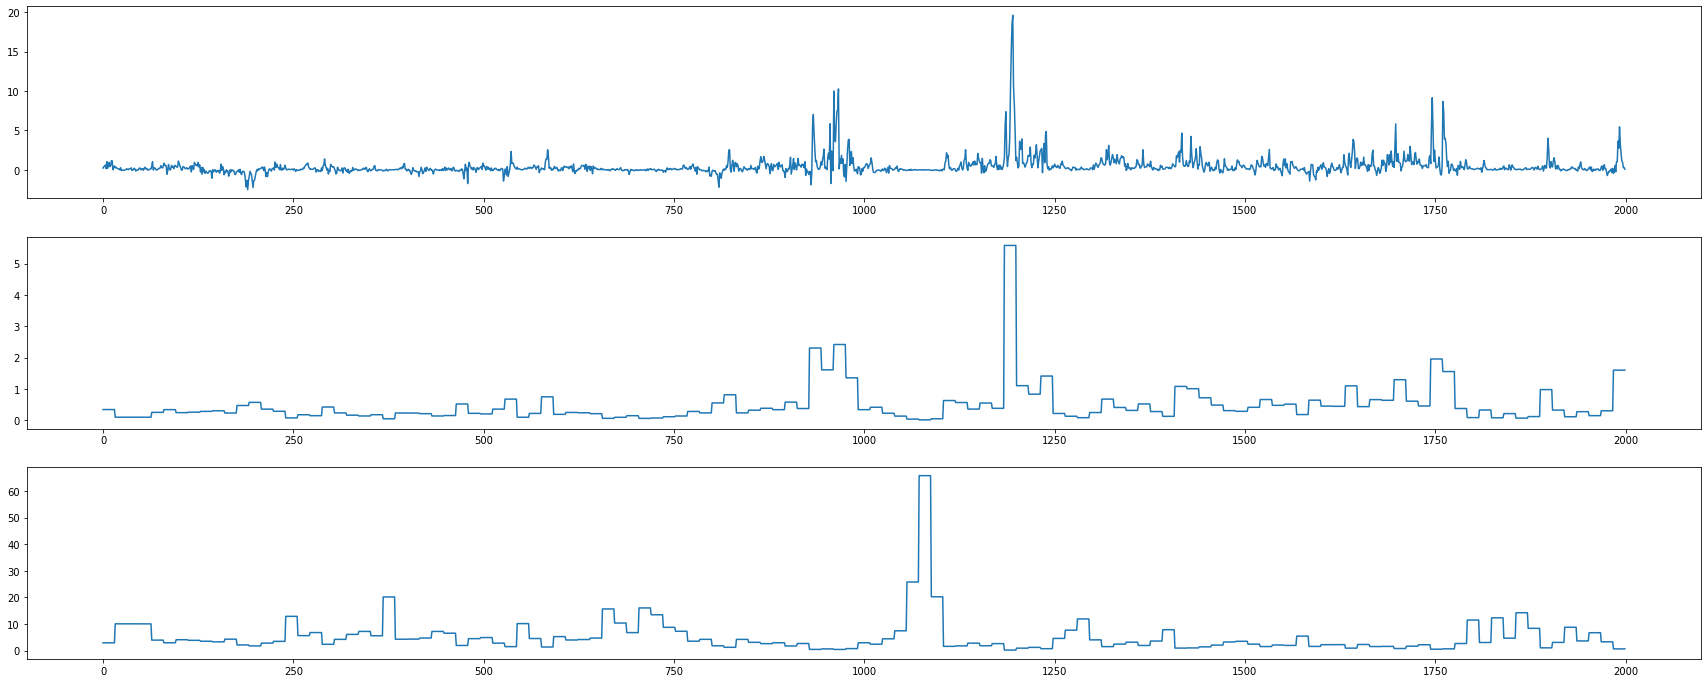

In [16]:
# plot_q_fluctuation(multifractal_noise[:2000], 16, axis_limit=[0,70])
plot_q_fluctuation(multifractal_noise[:2000], 16)

Range of F vals across q order at small scale shows exponential increase for multifractal

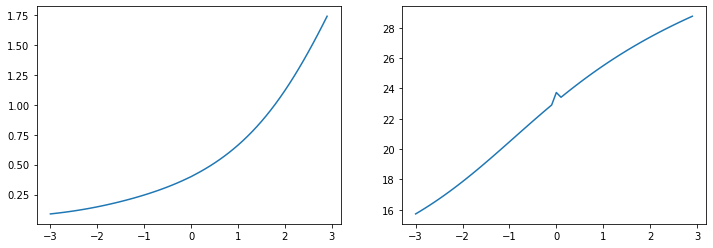

In [103]:
compare_fluctuation_at_scale(multifractal_walk)

### Monofractal

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

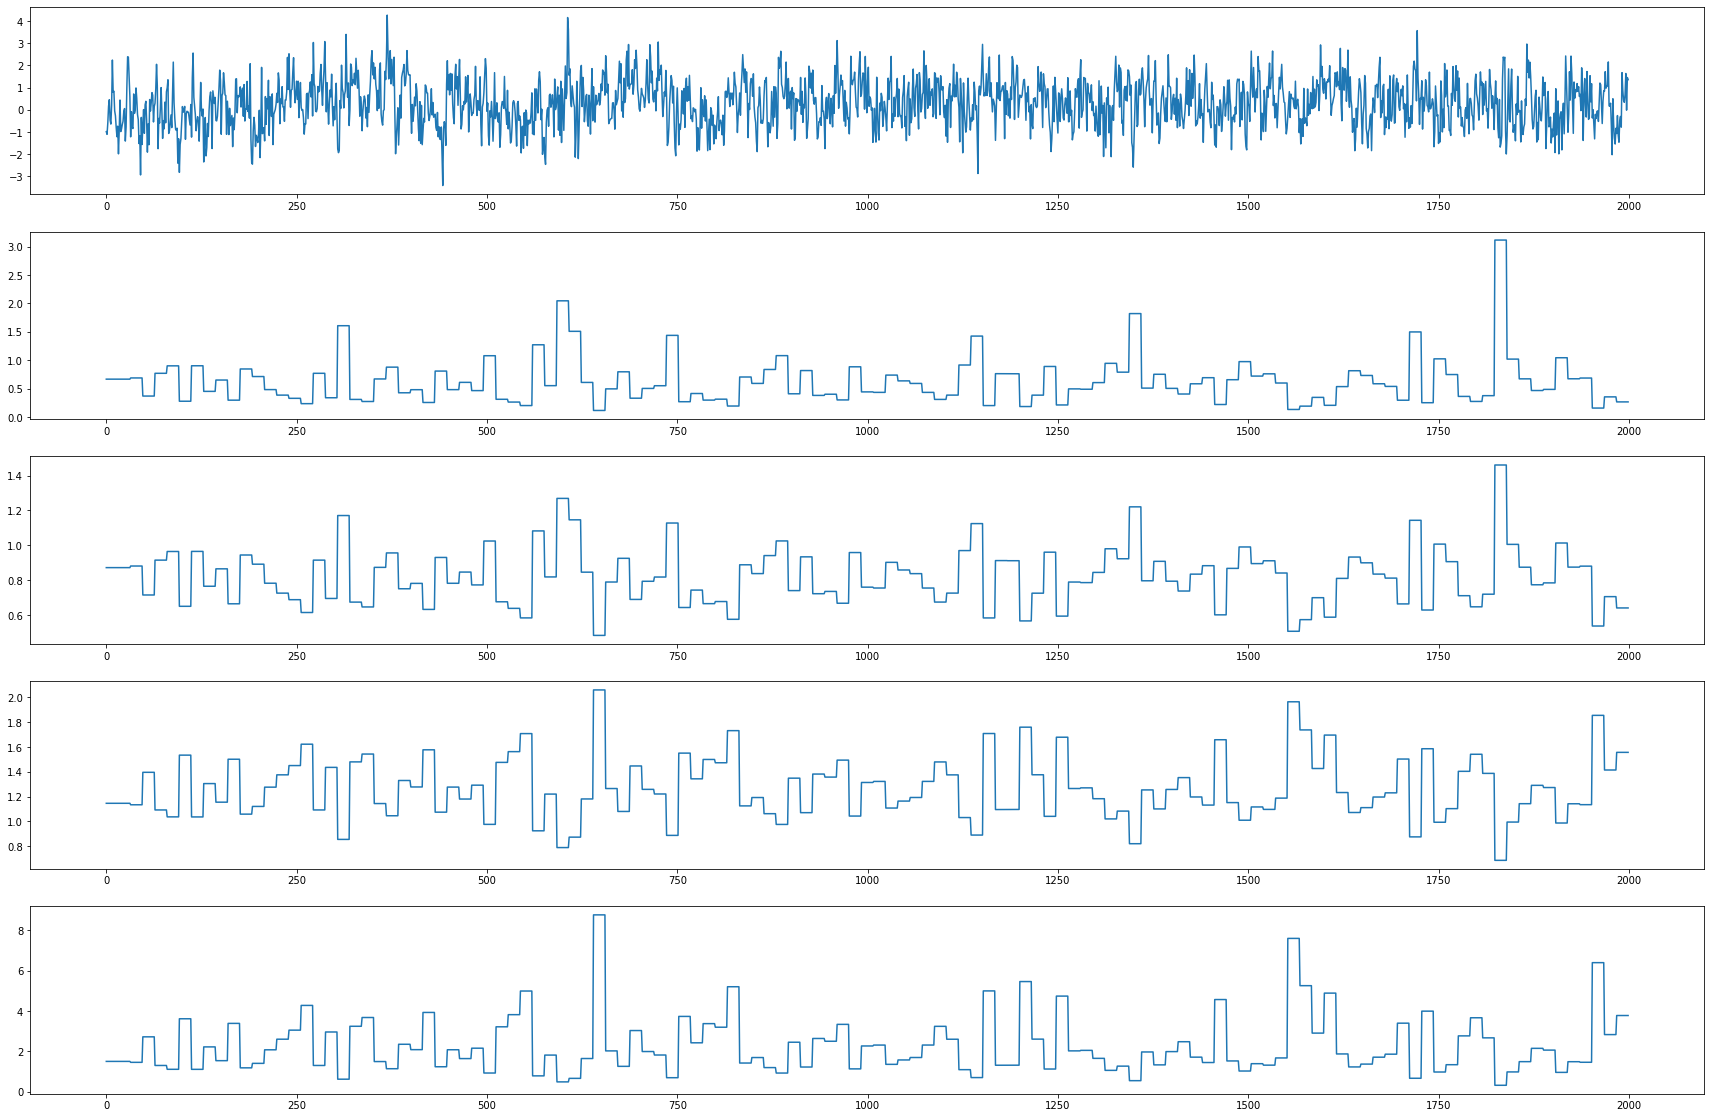

In [20]:
plot_q_fluctuation(monofractal_noise[:2000], 16, qs=[3,1,-1,-3])

Range of F vals across q-order at low scaling shows linear increase for monofractals

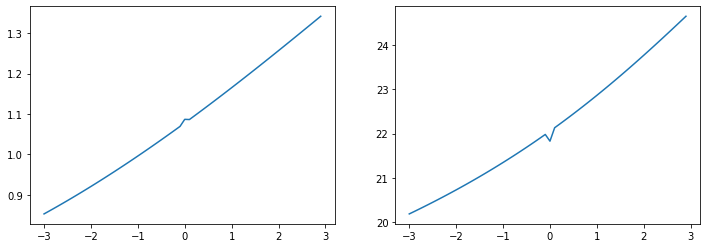

In [104]:
compare_fluctuation_at_scale(monofractal_walk)